<a href="https://colab.research.google.com/github/Prakadeeswaran05/Pose-graph-optimization-GTSAM/blob/main/GTSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gtsam
!pip install -q -U gtbook
import gtsam
from gtsam.utils import plot
import matplotlib.pyplot as plt
from gtbook.display import show

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00


In [2]:
!wget https://www.dropbox.com/s/vcz8cag7bo0zlaj/input_INTEL_g2o.g2o?dl=0
!wget https://www.dropbox.com/s/zu23p8d522qccor/parking-garage.g2o?dl=0

--2023-09-08 15:47:06--  https://www.dropbox.com/s/vcz8cag7bo0zlaj/input_INTEL_g2o.g2o?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/vcz8cag7bo0zlaj/input_INTEL_g2o.g2o [following]
--2023-09-08 15:47:06--  https://www.dropbox.com/s/raw/vcz8cag7bo0zlaj/input_INTEL_g2o.g2o
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca38f20e5b8f6134a7a9cd000b9.dl.dropboxusercontent.com/cd/0/inline/CDXBpe6p6-mtVzTUKOC9yHJeL15MK9AHVGGNLreoCPVSTUaPtOza_DJIyeOiMvC3rEP0VxmFWBsk1oBSGr56ER03pdi1kwE5fEMWTF8lSISjdEz6Mk6GGQqzJt2yT1KqkpM/file# [following]
--2023-09-08 15:47:07--  https://uca38f20e5b8f6134a7a9cd000b9.dl.dropboxusercontent.com/cd/0/inline/CDXBpe6p6-mtVzTUKOC9yHJeL15MK9AHVGGNLreoCPVSTUaPtOza_DJIyeOiMvC3rEP0VxmFWBsk1oBSGr56ER03pdi1kwE5f

In [3]:
def read_g2o_file(input_file):
  poses=[]
  edges=[]

  with open(input_file, "r+")  as file1:
    for line in file1:
      val=line.rstrip().split(" ")

      if val[0]=="VERTEX_SE2" or val[0]=="VERTEX_SE3:QUAT":
        pose = [float(x) for x in val[1:]] #(idp,x,y,θ)

        poses.append(pose)

      else:
        edge=[float(x) for x in val[1:]]   #(ide1, ide2, dx, dy, dθ, info)
        edges.append(edge)
  return poses,edges



-------Batch solution 2D-------
initial error =  2574860.522394622
final error =  1546783345.5742002


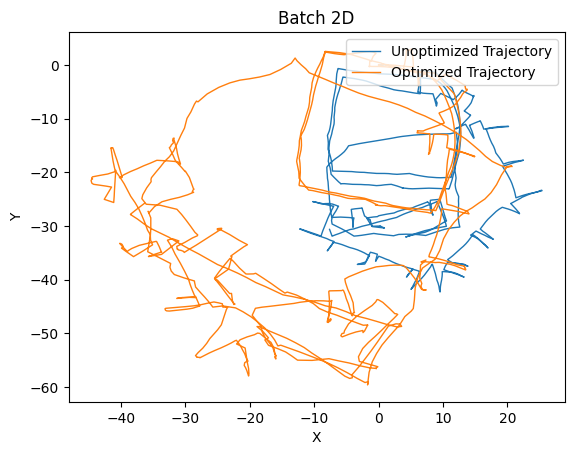

In [4]:
#Batch solution
import gtsam
graph, initial=gtsam.readG2o('/content/input_INTEL_g2o.g2o?dl=0',is3D = False)

# Add prior on the pose having index (key) = 0
priorModel = gtsam.noiseModel.Diagonal.Variances(gtsam.Point3(1e-6, 1e-6, 1e-8))
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(), priorModel))

params = gtsam.GaussNewtonParams()
# Create the optimizer ...
optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)
# ... and optimize
result = optimizer.optimize()
InitialPoses = gtsam.utilities.extractPose2(initial)
resultPoses = gtsam.utilities.extractPose2(result)
print('-------Batch solution 2D-------')
print("initial error = ", graph.error(initial))
print("final error = ", graph.error(result))
# Plotting the initial and results as Unoptimized and Optimized Trajectory respectively
fig, ax = plt.subplots()
ax.plot(InitialPoses[:,0], InitialPoses[:,1], linewidth=1.0, label="Unoptimized Trajectory")
ax.plot(resultPoses[:,0], resultPoses[:,1], linewidth=1.0, label = "Optimized Trajectory")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('Batch 2D')
plt.legend(loc='upper right')
plt.show()


-------Incremental solution 2D-------
initial error =  0.40162105985587543
final error =  1.0296726578112302e-06


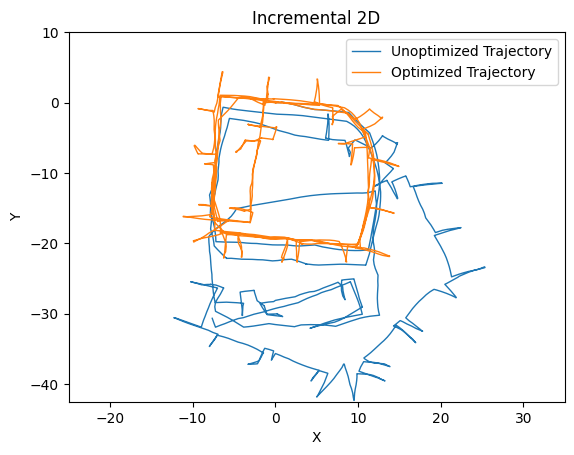

In [5]:
# Incremental solution
import numpy as np

def construct_covariance(info):
  np_info=np.array([[info0,info1,info2],
                   [info1,info3,info4],
                   [info2,info4,info5]])
  covariance_matrix=np.linalg.inv(np_info)
  return covariance_matrix



poses,edges=read_g2o_file('/content/input_INTEL_g2o.g2o?dl=0')
isam = gtsam.ISAM2()
init_poses=[]
initial=gtsam.Values()
for pose in poses:
   graph = gtsam.NonlinearFactorGraph()
   initial_estimate = gtsam.Values()
   (idp,x,y,theta)=pose
   idp=int(idp)
   init_poses.append([x,y,theta])
   if idp==0:
    priorNoise= gtsam.noiseModel.Diagonal.Sigmas((0.2, 0.2, 0.1))
    graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(x,y,theta), priorNoise))
    initial_estimate.insert(idp, gtsam.Pose2(x, y, theta))
    initial.insert(idp, gtsam.Pose2(x, y, theta))
   else:
    prevPose=result.atPose2(idp-1)
    initial_estimate.insert(idp,prevPose)
    initial.insert(idp,prevPose)
    for edge in edges:

      (ide1,ide2,dx,dy,dtheta,info0,info1,info2,info3,info4,info5)= edge
      info=[info0,info1,info2,info3,info4,info5]
      ide1=int(ide1)
      ide2=int(ide2)
      if ide2==idp:
        cov=construct_covariance(info)
        Model = gtsam.noiseModel.Gaussian.Covariance(cov)
        graph.add(gtsam.BetweenFactorPose2(ide1, ide2, gtsam.Pose2(dx,dy,dtheta), Model))

   isam.update(graph,initial_estimate)
   result= isam.calculateEstimate()

InitialPoses =np.array(init_poses)
resultPoses = gtsam.utilities.extractPose2(result)
# run opt
print('-------Incremental solution 2D-------')
print("initial error = ", graph.error(initial))
print("final error = ", graph.error(result))
fig, ax = plt.subplots()
ax.plot(InitialPoses[:,0], InitialPoses[:,1], linewidth=1.0, label="Unoptimized Trajectory")
ax.plot(resultPoses[:,0], resultPoses[:,1], linewidth=1.0, label = "Optimized Trajectory")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.ylim(-42.5, 10)
plt.xlim(-25, 35)
plt.title('Incremental 2D')
plt.legend(loc='upper right')
plt.show()


-------Batch solution 3D-------
initial error =  8363.601948120006
final error =  0.6341926461149362


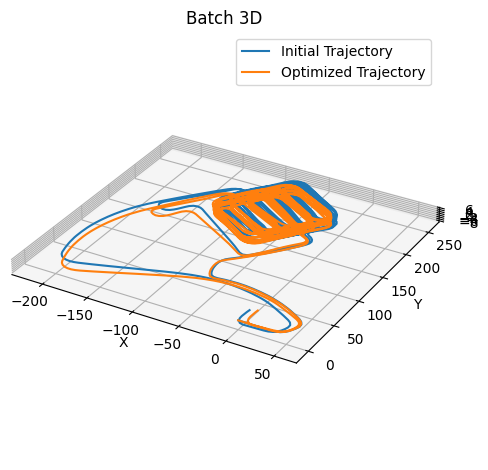

In [6]:
#Barch solution 3D
import gtsam
import numpy as np
import plotly.express as px
from gtbook.drone import axes
graph, initial=gtsam.readG2o('/content/parking-garage.g2o?dl=0',is3D =True)

# Add prior on the pose having index (key) = 0
priorModel = gtsam.noiseModel.Diagonal.Variances(
        np.array([1e6, 1e6, 1e6, 1e4, 1e4, 1e4], dtype=float))
graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(), priorModel))

params = gtsam.GaussNewtonParams()
# Create the optimizer ...
optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)
# ... and optimize
result = optimizer.optimize()
InitialPoses = gtsam.utilities.extractPose3(initial)
resultPoses = gtsam.utilities.extractPose3(result)
print('-------Batch solution 3D-------')
print("initial error = ", graph.error(initial))
print("final error = ", graph.error(result))
# Plotting the initial and results as Unoptimized and Optimized Trajectory respectively
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

before=InitialPoses[:, -3:]
after= resultPoses[:, -3:]
ax.plot(before[:, 0], before[:, 1], before[:, 2], label="Initial Trajectory")
ax.plot(after[:, 0], after[:, 1], after[:, 2],  label="Optimized Trajectory")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect((np.ptp(after[:, 0]), np.ptp(after[:, 1]), np.ptp(after[:, 2])))
plt.grid()
plt.legend()
plt.title('Batch 3D')

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
poses,edges=read_g2o_file('/content/parking-garage.g2o?dl=0')
isam = gtsam.ISAM2()
init_poses=[]
initial=gtsam.Values()

def construct_covariance_3d(info):
  np_info=np.array([[info[0], info[1], info[2], info[3], info[4], info[5]],
                       [info[1], info[6], info[7], info[8], info[9], info[10]],
                       [info[2], info[7], info[11], info[12], info[13], info[14]],
                       [info[3], info[8], info[12], info[15], info[16], info[17]],
                       [info[4], info[9], info[13], info[16], info[18], info[19]],
                       [info[5], info[10], info[14], info[17], info[19], info[20]]])
  covariance_matrix=np.linalg.inv(np_info)
  return covariance_matrix

for pose in poses:
  #print(pose)
  graph = gtsam.NonlinearFactorGraph()
  initial_estimate = gtsam.Values()
  (idp,x,y,z,qx,qy,qz,qw)=pose
  idp=int(idp)
  init_poses.append([x,y,z])
  if idp==0:
    r = gtsam.Rot3.Quaternion(qw,qx,qy,qz)
    t = gtsam.Point3(x,y,z)
    priorNoise = gtsam.noiseModel.Diagonal.Variances(
        np.array([1e6, 1e6, 1e6, 1e4, 1e4, 1e4], dtype=float))
    graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(r,t), priorNoise))
    initial_estimate.insert(idp, gtsam.Pose3(r,t))
    initial.insert(idp, gtsam.Pose3(r,t))
  else:
    prevPose=result.atPose3(idp-1)
    initial_estimate.insert(idp,prevPose)
    initial.insert(idp,prevPose)
    for edge in edges:
       (ide1,ide2,dx,dy,dz,dqx,dqy,dqz,dqw,*info)= edge
       if ide2==idp:

        ide1=int(ide1)
        ide2=int(ide2)
        cov=construct_covariance_3d(info)
        Model = gtsam.noiseModel.Gaussian.Covariance(cov)
        r = gtsam.Rot3.Quaternion(dqw,dqx,dqy,dqz)
        t = gtsam.Point3(dx, dy, dz)
        graph.add(gtsam.BetweenFactorPose3(ide1,ide2,gtsam.Pose3(r,t),Model))
  isam.update(graph,initial_estimate)
  result= isam.calculateEstimate()

print('-------Incremental solution 3D-------')
print("initial error = ", graph.error(initial))
print("final error = ", graph.error(result))
  #print(len(pose))

-------Incremental solution 3D-------
initial error =  1.469091668184387
final error =  0.0959581713290726


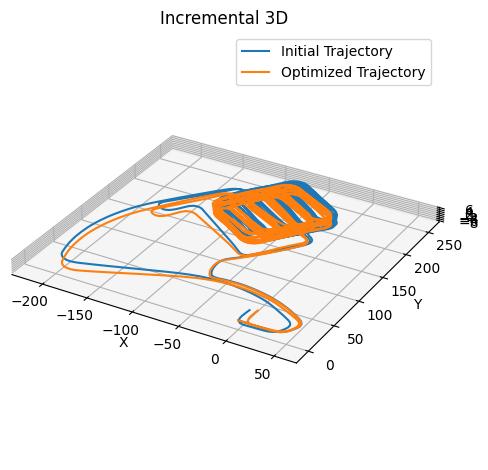

In [8]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

before=InitialPoses[:, -3:]
after= resultPoses[:, -3:]
ax.plot(before[:, 0], before[:, 1], before[:, 2], label="Initial Trajectory")
ax.plot(after[:, 0], after[:, 1], after[:, 2],  label="Optimized Trajectory")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect((np.ptp(after[:, 0]), np.ptp(after[:, 1]), np.ptp(after[:, 2])))

plt.grid()
plt.legend()
plt.title('Incremental 3D')
plt.tight_layout()
plt.show()